## Inter-subject node and edge time series (IS-NTS/ IS-ETS)

You will find in this notebook explanations and code examples of the inter-subject node/edge time-series (IS-NTS/ETS) method. Additionally, it includes numerical simulation demonstrating the advantage of the two measures in capturing stimulus-dependent shared co-activation/co-deactivation and FC co-fluctuations.

This work is based on the paper:
> Citation here [link](http://www.google.com)


## IS-NTS/ IS-ETS overview

The IS-NTS/ IS-ETS methods allow us to measure frame-wise fluctuations in inter-subject functional connectivity. We can compute this measure within homologous ROIs/voxels to derive a stimulus-locked version of the signal, resulting in the IS-NTS. We can also calculate these fluctuations across different ROIs/voxels to examine how stimulus-locked connectivity changes in time, resulting in the IS-ETS.

## IS-NTS/ IS-ETS explanation with a simple example

Let’s explain this with a simple example. We first simulate the neuronal activities of two individuals who watched the same stimulus. The activity of each region is composed of a shared response to the stimulus and an idiosyncratic response/noise. A weights vector determined the balance between the two:

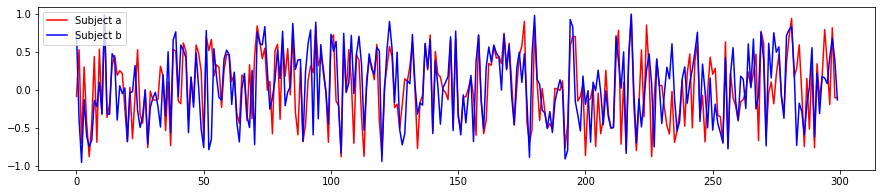

In [16]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

n_tr=300 # number of samples time points
common_response = np.random.random(n_tr)*2-1
weights_vector = np.random.random(n_tr)*0.75

idiosync_noise = np.random.random(n_tr)*2-1
subjects_a_signal = weights_vector*idiosync_noise + \
                    (1-weights_vector)*common_response

idiosync_noise = np.random.random(n_tr)*2-1
subjects_b_signal = weights_vector*idiosync_noise + \
                    (1-weights_vector)*common_response

# now plot:
plt.figure(figsize=(15,3))
plt.plot(subjects_a_signal, label='Subject a', c='r')
plt.plot(subjects_b_signal, label='Subject b', c='b')
plt.legend()

Now we compute the edge time series between regions (Esfahlani et al., 2020). This is simply calculated as the element-wise multiplications of the z-scored signals:

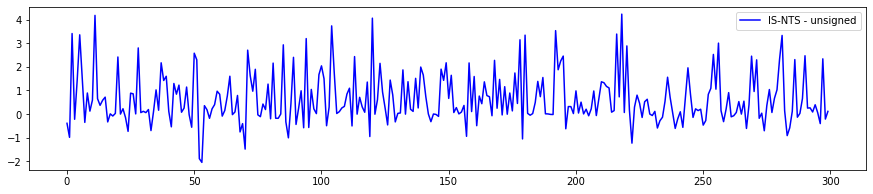

In [17]:
from scipy import stats

unsigned_is_ets = stats.zscore(subjects_a_signal) * stats.zscore(subjects_b_signal)

# now plot:
plt.figure(figsize=(15,3))
plt.plot(unsigned_is_ets, label='IS-NTS - unsigned', c='b')
plt.legend()

As you can see, high ETS values indicate points in time of high IS synchrony, and low values indicate low synchrony. When calculating IS-NTS we add another step. To differentiate between co-activation and co-deactivation across subjects, we multiply this time-series by the sign of the BOLD signal to derive the IS-NTS. Now, the IS-NTS can be viewed as an approximation of stimulus-dependent shared:

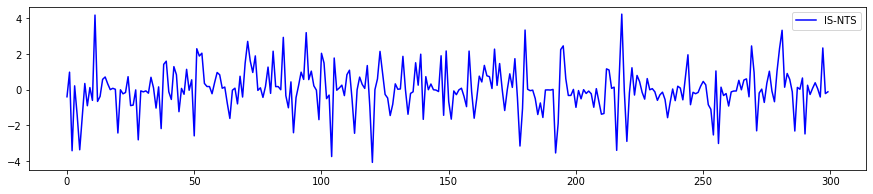

In [18]:
from scipy import stats

is_ets = stats.zscore(subjects_a_signal) * \
         stats.zscore(subjects_b_signal) * \
         np.sign(subjects_b_signal)

# now plot:
plt.figure(figsize=(15,3))
plt.plot(is_ets, label='IS-NTS', c='b')
plt.legend()

 We computed IS-ETS similarly, without the sign multiplication.

<br>
Next, we conduct a multi-subjects simulation to test how both IS node and edge time series (IS-NTS/ETS) methods capture stimulus-locked activity and connectivity co-fluctuations. We simulate the neural activity of two brain regions, a and b, during a typical fMRI experiment. We first import the IS-NTS/ETS function from the standalone implementation:

In [22]:
# We first import the IS-NTS/ETS function from the standalone implementation
url = f"https://raw.githubusercontent.com/GidLev/dynamic_faces_2022/master/isc_standalone.py"
!wget --no-cache --backups=1 {url}
from isc_standalone import isc_ets, isfc_ets

# define some parameters (this can be changed):
n=40 # number of subjects
n_tr=300 # number of samples time points

common_response = np.random.random(n_tr)*2-1
weights_vector = np.random.random(n_tr)
subjects_signal = np.zeros((n_tr, 2, n))
for sub_i in range(n):
  # brain region a
  idiosync_noise = np.random.random(n_tr)*2-1
  subjects_signal[:,0,sub_i] = weights_vector*idiosync_noise + \
                               (weights_vector-1)*common_response
  # brain region b
  idiosync_noise = np.random.random(n_tr)*2-1
  subjects_signal[:,1,sub_i] = weights_vector*idiosync_noise + \
                               (weights_vector-1)*common_response

# compute the IS-NTS
is_nts = isc_ets(subjects_signal) 
is_nts = is_nts * np.transpose(np.sign(subjects_signal), axes=(2,0,1))
# compute the IS-ETS
is_ets = isfc_ets(subjects_signal)
# compute the within subjects edge time series (ETS)
subjects_signal_zscored = stats.zscore(subjects_signal)
ets = np.transpose(subjects_signal_zscored, axes=(2,0,1))[:,:,0] * \
      np.transpose(subjects_signal_zscored, axes=(2,0,1))[:,:,1]

--2022-04-07 08:05:40--  https://raw.githubusercontent.com/GidLev/dynamic_faces_2022/master/isc_standalone.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99128 (97K) [text/plain]
Saving to: ‘isc_standalone.py’

isc_standalone.py   100%[===================>]  96.80K  --.-KB/s    in 0.02s   

2022-04-07 08:05:40 (5.87 MB/s) - ‘isc_standalone.py’ saved [99128/99128]



Now, let’s test the results and plot them:

--2022-04-07 08:05:45--  https://raw.githubusercontent.com/GidLev/dynamic_faces_2022/master/plot_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1387 (1.4K) [text/plain]
Saving to: ‘plot_utils.py’

plot_utils.py       100%[===================>]   1.35K  --.-KB/s    in 0s      

2022-04-07 08:05:45 (23.7 MB/s) - ‘plot_utils.py’ saved [1387/1387]



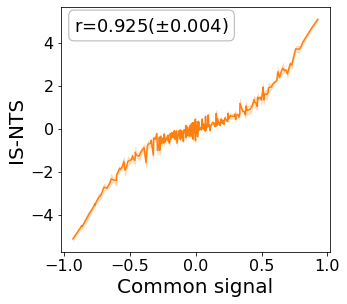

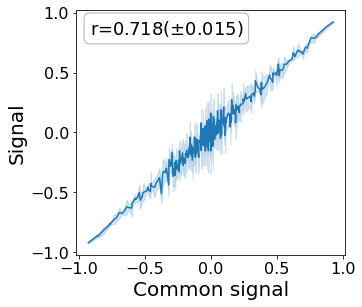

IS-NTS vs signal: t=92.028, p=3.15e-47


In [23]:
# Download and import a plotting function
url = f"https://raw.githubusercontent.com/GidLev/dynamic_faces_2022/master/plot_utils.py"
!wget --no-cache --backups=1 {url}
from plot_utils import scatter_subs_sim

# The similarity of the IS-NTS measure to the common signal 
# common signal = (weights_vector-1) * common_response
x_label = 'Common signal'
correls_is_nts = scatter_subs_sim(
    common_response * (weights_vector-1), is_nts[:,:,0], xlabel=x_label,  
    color='tab:orange', y_label='IS-NTS')

# The similarity of the original signal the common signal 
correls_signal = scatter_subs_sim(
    common_response * (weights_vector-1), np.transpose(subjects_signal, axes=(2,0,1))[:,:,0],
    xlabel=x_label, y_label='Signal')

The correlation of IS-NTS measure with the shared signal should be significantly higher than with the original signal. We quantify this with a t-test between the correlation values:

In [24]:
# test the difference between the two
t, p = stats.ttest_rel(correls_is_nts, correls_signal)
print('IS-NTS vs signal: t={:.3f}, p={:.2e}'.format(t,p))

IS-NTS vs signal: t=92.028, p=3.15e-47


Next, as the common signal was shared across regions a and b, it effectively drove their shared co-fluctuations. Hence, we compared the amplitude of the shared co-fluctuations (|([weight vector] – 1)* common_response|) to both the edge-time series and the IS-ETS between regions a and b:

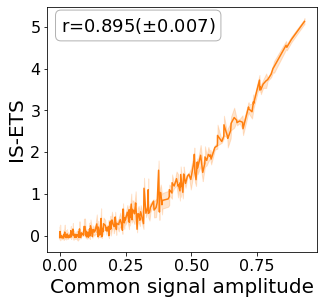

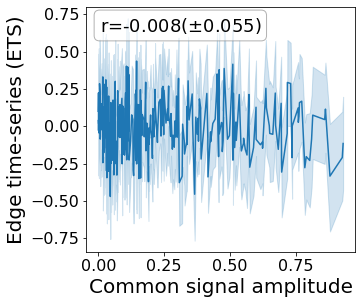

In [26]:
x_label = 'Common signal amplitude'
# The similarity of the IS-ETS measure to the common signal amplitude
correls_is_ets = scatter_subs_sim(
    np.abs(common_response * (weights_vector-1)), is_ets[:,:,0,0], xlabel=x_label,
    color='tab:orange', y_label='IS-ETS')

# The similarity of the ETS measure to the common signal amplitude
correls_ets = scatter_subs_sim(
    np.abs(common_response * (weights_vector-1)), ets, xlabel=x_label,
    y_label='Edge time-series (ETS)')

Again, the correlation of IS-ETS measure with the shared signal amplitude should be significantly higher than with the within subjects ETS. We quantify this with a t-test between the correlation values:

In [27]:
t, p = stats.ttest_rel(correls_is_ets, correls_ets)
print('IS-ETS vs ETS: t={:.3f}, p={:.2e}'.format(t,p))

IS-ETS vs ETS: t=103.811, p=2.92e-49
